<a href="https://colab.research.google.com/github/mgovindasamy/Machine-Learning-Examples/blob/master/JPY-tax-research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install download

In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from download import download

In [30]:
data = pd.read_csv('https://raw.githubusercontent.com/mgovindasamy/Machine-Learning-Examples/master/tesla.csv')
data.head
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2193 non-null   object 
 1   Open       2193 non-null   float64
 2   High       2193 non-null   float64
 3   Low        2193 non-null   float64
 4   Close      2193 non-null   float64
 5   Adj Close  2193 non-null   float64
 6   Volume     2193 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 120.1+ KB


These Python technical indicators are popularly used in the markets to study the price movement, so we will be adding the following features in our research:
*   Commodity Channel Index
*   Ease of Movement
*   Moving Average
*   Rate of Change
*   Bollinger Bands
*   Force Index


Formula for the Commodity Channel Index
The formula for CCI is given by:

CCI = (Typical price – MA of Typical price) / (0.015 * mean deviation of Typical price)
0.015 is Lambert's constant.

Estimation
To calculate the EMV we first calculate the distance moved. It is given by:

Distance moved = ((Current High + Current Low)/2 - (Prior High + Prior Low)/2)


To compute the 20-day EMA, we first compute the very first EMA value using a simple moving average. Then we calculate the multiplier, and thereafter to compute the second EMA value we use the multiplier and the previous day EMA. This formula is used to compute the subsequent EMA values.

SMA: 20 period sum / 20
Multiplier: (2 / (Time periods + 1)) = (2 / (20 + 1)) = 9.52%
EMA: {Close price - EMA(previous day)} x multiplier + EMA(previous day).

Estimation
ROC = [(Close price today - Close price “n” day’s ago) / Close price “n” day’s ago))]

Bollinger bands expand and contract based on the volatility. During a period of rising volatility, the bands widen, and they contract as the volatility decreases. Prices are considered to be relatively high when they move above the upper band and relatively low when they go below the lower band.

Estimation
To create the bands, we first compute the SMA and then use this to compute the bands values.

Middle Band = 20-day simple moving average (SMA)
Upper Band = 20-day SMA + (2 x 20-day standard deviation of price)
Lower Band = 20-day SMA - (2 x 20-day standard deviation of price)

Estimation
Example: Computing Force index(1) and Force index(15) period.

The Force index(1) = {Close (current period) - Close (prior period)} x Current period Volume
The Force Index for the 15-day period is an exponential moving average of the 1-period Force Index.



In [31]:
# Commodity Channel Index 
def CCI(df, ndays): 
  df['TP'] = (data['High'] + data['Low'] + data['Close']) / 3 
  df['sma'] = df['TP'].rolling(ndays).mean()
  df['mad'] = df['TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
  df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
  return df

In [32]:
# Ease of Movement 
def EVM(df, ndays): 
 dm = ((df['High'] + df['Low'])/2) - ((df['High'].shift(1) + df['Low'].shift(1))/2)
 br = (df['Volume'] / 100000000) / ((df['High'] - df['Low']))
 EVM = dm / br 
 EVM_MA = pd.Series(EVM.rolling(ndays).mean(), name = 'EVM') 
 df = df.join(EVM_MA) 
 return df 

In [33]:
# Simple Moving Average 
def SMA(df, ndays): 
 SMA = pd.Series(df['Close'].rolling(ndays).mean(), name = 'SMA') 
 df = df.join(SMA) 
 return df

In [34]:
# Exponentially-weighted Moving Average 
def EWMA(df, ndays): 
 EMA = pd.Series(df['Close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
 df = df.join(EMA) 
 return df

In [35]:
# Rate of Change (ROC)
def ROC(df,ndays):
 N = df['Close'].diff(ndays)
 D = df['Close'].shift(ndays)
 ROC = pd.Series(N/D,name='Rate of Change')
 df = df.join(ROC)
 return df 

In [36]:
# Compute the Bollinger Bands 
def BBANDS(df, ndays):
    MA = df.Close.rolling(ndays).mean()
    SD = df.Close.rolling(ndays).std()
    df['UpperBB'] = MA + (2 * SD) 
    df['LowerBB'] = MA - (2 * SD)
    return data

In [37]:
# Force Index 
def ForceIndex(df, ndays): 
    FI = pd.Series(df['Close'].diff(ndays) * df['Volume'], name = 'ForceIndex') 
    df = df.join(FI) 
    return df

In [38]:
# Compute the 5-period Rate of Change for NIFTY
n = 3

In [39]:
NIFTY_ROC = ROC(data,n)
BB = BBANDS(data,n)
EM = EWMA(data,n)
SM = SMA(data,n)
EV = EVM(data,n)
CC = CCI(data,n)
FI = ForceIndex(data,n)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,UpperBB,LowerBB,TP,sma,mad,CCI
0,29-06-2010,19.000000,25.00,17.540001,23.889999,23.889999,18766300,NaN,NaN,22.143333,NaN,NaN,NaN
1,30-06-2010,25.790001,30.42,23.299999,23.830000,23.830000,17187100,NaN,NaN,25.850000,NaN,NaN,NaN
2,01-07-2010,25.000000,25.92,20.270000,21.959999,21.959999,8218800,25.421418,21.031914,22.716666,23.570000,1.520000,-37.426907
3,02-07-2010,23.000000,23.10,18.709999,19.200001,19.200001,5139800,26.321758,17.004908,20.336667,22.967778,1.921481,-91.287583
4,06-07-2010,20.000000,20.00,15.830000,16.110001,16.110001,6866900,24.943100,13.236901,17.313334,20.122222,1.872592,-100.000000


In [40]:
FI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2193 non-null   object 
 1   Open        2193 non-null   float64
 2   High        2193 non-null   float64
 3   Low         2193 non-null   float64
 4   Close       2193 non-null   float64
 5   Adj Close   2193 non-null   float64
 6   Volume      2193 non-null   int64  
 7   UpperBB     2191 non-null   float64
 8   LowerBB     2191 non-null   float64
 9   TP          2193 non-null   float64
 10  sma         2191 non-null   float64
 11  mad         2191 non-null   float64
 12  CCI         2191 non-null   float64
 13  ForceIndex  2190 non-null   float64
dtypes: float64(12), int64(1), object(1)
memory usage: 240.0+ KB


In [42]:
data = data.dropna()

In [43]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,UpperBB,LowerBB,TP,sma,mad,CCI
2,01-07-2010,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,25.421418,21.031914,22.716666,23.570000,1.520000,-37.426907
3,02-07-2010,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,26.321758,17.004908,20.336667,22.967778,1.921481,-91.287583
4,06-07-2010,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,24.943100,13.236901,17.313334,20.122222,1.872592,-100.000000
5,07-07-2010,16.400000,16.629999,14.980000,15.800000,15.800000,6921700,20.796473,13.276862,15.803333,17.817778,1.679259,-79.973547
6,08-07-2010,16.139999,17.520000,15.570000,17.459999,17.459999,7711400,18.221922,14.691411,16.850000,16.655555,0.568148,22.816135


In [47]:
print(data.value_counts())

Date        Open        High        Low         Close       Adj Close   Volume   UpperBB     LowerBB     TP          sma         mad       CCI        
01-02-2011  24.309999   24.730000   23.540001   23.910000   23.910000   707800   24.196754   23.816579   24.060000   24.060000   0.102222   0.000145      1
21-03-2014  236.020004  236.199997  227.500000  228.889999  228.889999  8216900  240.759096  225.667570  230.863332  234.556666  2.462223  -100.000000    1
21-02-2017  275.450012  281.399994  274.010010  277.390015  277.390015  5676700  281.366191  264.347168  277.600006  273.280006  2.880000   100.000000    1
21-02-2018  336.029999  339.690002  333.170013  333.299988  333.299988  3219600  336.752389  332.287589  335.386668  335.946665  0.535556  -69.709137     1
21-02-2019  301.809998  303.239990  290.500000  291.230011  291.230011  8909200  314.986818  284.633198  294.990000  301.720001  4.486667  -100.000000    1
                                                                     

In [48]:
trainData = data.iloc[:,4:12].values

In [52]:
sc = MinMaxScaler(feature_range=(0,7))
trainData = sc.fit_transform(trainData)
trainData.shape

(2191, 8)

In [53]:
X_train = []
y_train = []

for i in range (60,2191): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [54]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(2131, 60, 1)

In [55]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [56]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
67/67 - 16s - loss: 1.1313 - 16s/epoch - 232ms/step
Epoch 2/20
67/67 - 9s - loss: 0.1708 - 9s/epoch - 132ms/step
Epoch 3/20
67/67 - 10s - loss: 0.1843 - 10s/epoch - 156ms/step
Epoch 4/20
67/67 - 12s - loss: 0.1611 - 12s/epoch - 172ms/step
Epoch 5/20
67/67 - 9s - loss: 0.1529 - 9s/epoch - 134ms/step
Epoch 6/20
67/67 - 9s - loss: 0.1337 - 9s/epoch - 132ms/step
Epoch 7/20
67/67 - 9s - loss: 0.1254 - 9s/epoch - 137ms/step
Epoch 8/20
67/67 - 14s - loss: 0.1146 - 14s/epoch - 214ms/step
Epoch 9/20
67/67 - 10s - loss: 0.1373 - 10s/epoch - 151ms/step
Epoch 10/20
67/67 - 9s - loss: 0.1022 - 9s/epoch - 132ms/step
Epoch 11/20
67/67 - 10s - loss: 0.0962 - 10s/epoch - 152ms/step
Epoch 12/20
67/67 - 9s - loss: 0.1176 - 9s/epoch - 133ms/step
Epoch 13/20
67/67 - 15s - loss: 0.0894 - 15s/epoch - 227ms/step
Epoch 14/20
67/67 - 9s - loss: 0.0907 - 9s/epoch - 133ms/step
Epoch 15/20
67/67 - 9s - loss: 0.0904 - 9s/epoch - 133ms/step
Epoch 16/20
67/67 - 9s - loss: 0.0868 - 9s/epoch - 132ms/step
Epo

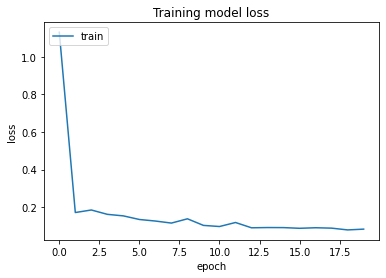

In [57]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
testData = pd.read_csv('https://raw.githubusercontent.com/mgovindasamy/Machine-Learning-Examples/master/Google_test_data.csv')
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
predicted_price = sc.inverse_transform(y_pred)

In [ ]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()